# Naive prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
np.random.seed(4312)

<Axes: title={'center': 'Random Walk Time Series'}>

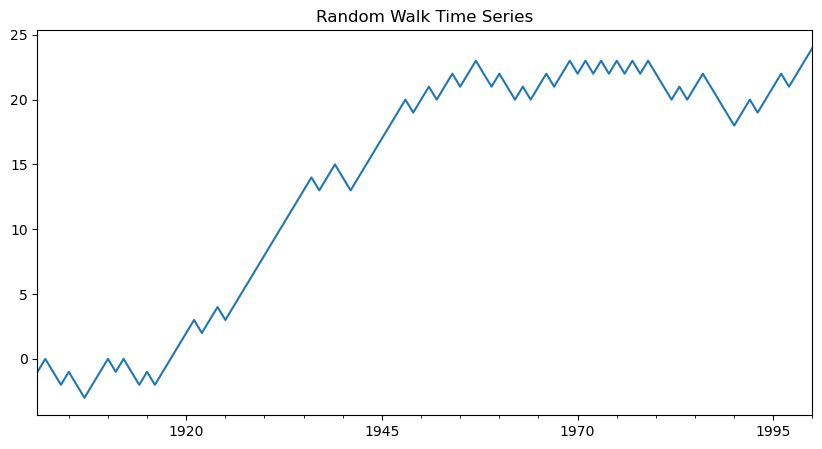

In [3]:
x = np.cumsum(np.random.choice([-1, 1], size = 100, replace = True))
series = pd.Series(x, index = pd.date_range(start = '1901', end = '2001', freq = 'YE'))
plt.figure(figsize = (10, 5))
series.plot(title = 'Random Walk Time Series')

In [4]:
model = SimpleExpSmoothing(series)
fit = model.fit(smoothing_level = 1, optimized = False)
prev = fit.forecast(5)
prev

2001-12-31    24.0
2002-12-31    24.0
2003-12-31    24.0
2004-12-31    24.0
2005-12-31    24.0
Freq: YE-DEC, dtype: float64

In [5]:
# Fit values and residuals
fitted_values = fit.fittedvalues
residuals = series - fitted_values

print(
f"""[fitted_values]: 
{fitted_values}

[residuals]: 
{residuals}
""")

[fitted_values]: 
1901-12-31    -1.0
1902-12-31    -1.0
1903-12-31     0.0
1904-12-31    -1.0
1905-12-31    -2.0
              ... 
1996-12-31    21.0
1997-12-31    22.0
1998-12-31    21.0
1999-12-31    22.0
2000-12-31    23.0
Freq: YE-DEC, Length: 100, dtype: float64

[residuals]: 
1901-12-31    0.0
1902-12-31    1.0
1903-12-31   -1.0
1904-12-31   -1.0
1905-12-31    1.0
             ... 
1996-12-31    1.0
1997-12-31   -1.0
1998-12-31    1.0
1999-12-31    1.0
2000-12-31    1.0
Freq: YE-DEC, Length: 100, dtype: float64



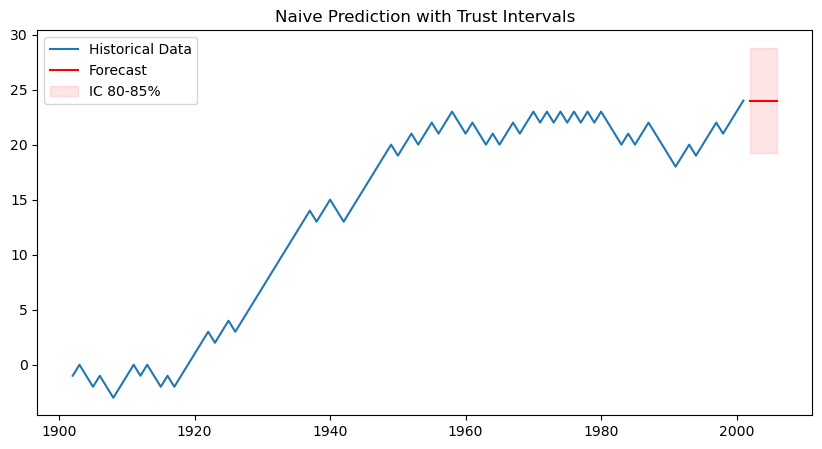

In [6]:
# Plor prediction with trust intervals
plt.figure(figsize = (10, 5))
plt.plot(series.index, series, label = 'Historical Data')
plt.plot(pd.date_range(start = '2001', periods = 5, freq = 'YE'), prev, label = 'Forecast', color = 'red')
plt.fill_between(pd.date_range(start = '2001', periods = 5, freq = 'YE'), prev * 0.8, prev * 1.2, color = 'red', alpha = 0.1, label = 'IC 80-85%')

plt.title('Naive Prediction with Trust Intervals')
plt.legend()

In [7]:
# Alterar o intervalo de confianca (é preciso usar outro metodo para ICs diferentes)
model_arima = ARIMA(series, order = (0,1,0)) # ARIMA(0,1,0) é equivalente a previsão Naive
fit_arima = model_arima.fit()
prev2 = fit_arima.get_forecast(steps = 5)
conf_int99 = prev2.conf_int(alpha = 0.01) # 99% IC
conf_int95 = prev2.conf_int(alpha = 0.05) # 95% IC

print(
f"""Previsao com diferentes ICs:
[Previsao pontual]: 
{prev2.predicted_mean}

[ICs Intervalos de Confianca (95% e 99%)]:
95%: {conf_int95}
99%: {conf_int99}
"""
)

Previsao com diferentes ICs:
[Previsao pontual]: 
2001-12-31    24.0
2002-12-31    24.0
2003-12-31    24.0
2004-12-31    24.0
2005-12-31    24.0
Freq: YE-DEC, Name: predicted_mean, dtype: float64

[ICs Intervalos de Confianca (95% e 99%)]:
95%:               lower y    upper y
2001-12-31  22.040047  25.959953
2002-12-31  21.228207  26.771793
2003-12-31  20.605261  27.394739
2004-12-31  20.080093  27.919907
2005-12-31  19.617411  28.382589
99%:               lower y    upper y
2001-12-31  21.424185  26.575815
2002-12-31  20.357247  27.642753
2003-12-31  19.538557  28.461443
2004-12-31  18.848369  29.151631
2005-12-31  18.240302  29.759698



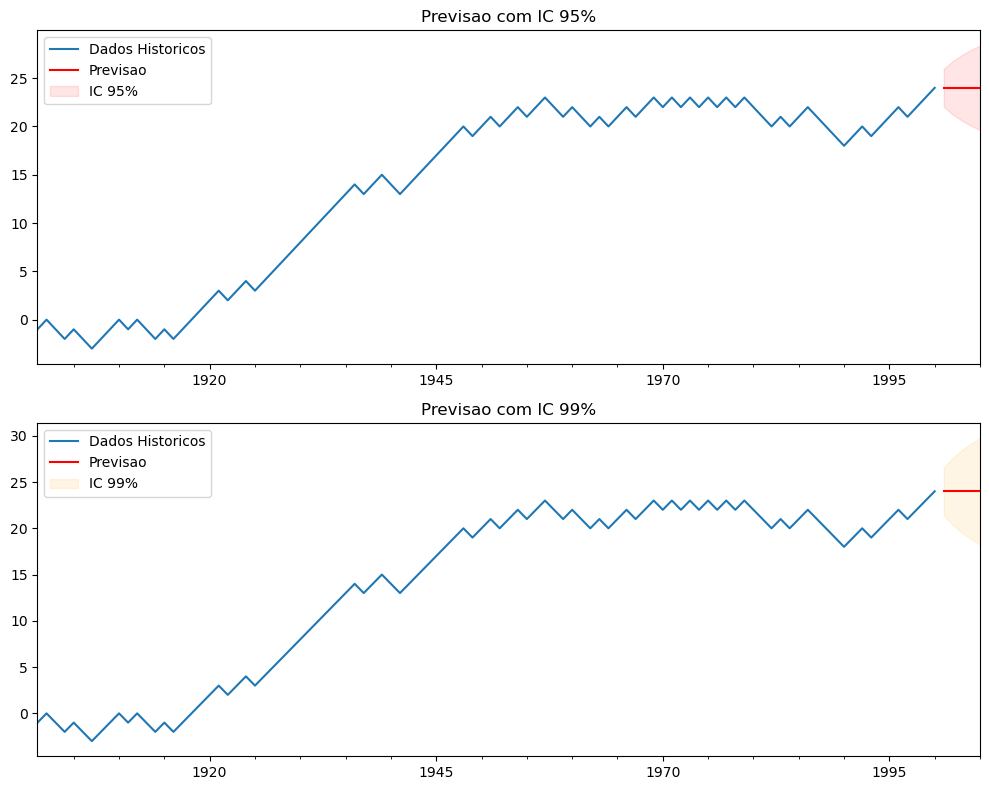

In [8]:
# Plotar comparacao
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 8))

# Plot 1 - Previsao original
series.plot(ax = ax1, label = 'Dados Historicos' )
prev2.predicted_mean.plot(ax = ax1, color = 'red', label = 'Previsao')
ax1.fill_between(prev2.predicted_mean.index, conf_int95.iloc[:, 0], conf_int95.iloc[:, 1], color = 'red', alpha = 0.1, label = 'IC 95%')
ax1.set_title('Previsao com IC 95%')
ax1.legend()

# Plot 2 - Previsao com multiplos ICs 
series.plot(ax = ax2, label = 'Dados Historicos')
prev2.predicted_mean.plot(ax = ax2, color = 'red', label = 'Previsao')
ax2.fill_between(prev2.predicted_mean.index, conf_int99.iloc[:, 0], conf_int99.iloc[:, 1], color = 'orange', alpha = 0.1, label = 'IC 99%')
ax2.set_title('Previsao com IC 99%') 
ax2.legend()

plt.tight_layout()

In [10]:
# Naive sazonal - usando AirPassengers
air_passengers = sm.datasets.get_rdataset('AirPassengers', 'datasets').data
air_passengers['time'] = pd.to_datetime(air_passengers['time'])
air_passengers.set_index('time', inplace = True)
air_series = air_passengers['value']

<Axes: title={'center': 'AirPassengers Time Series'}, xlabel='time'>

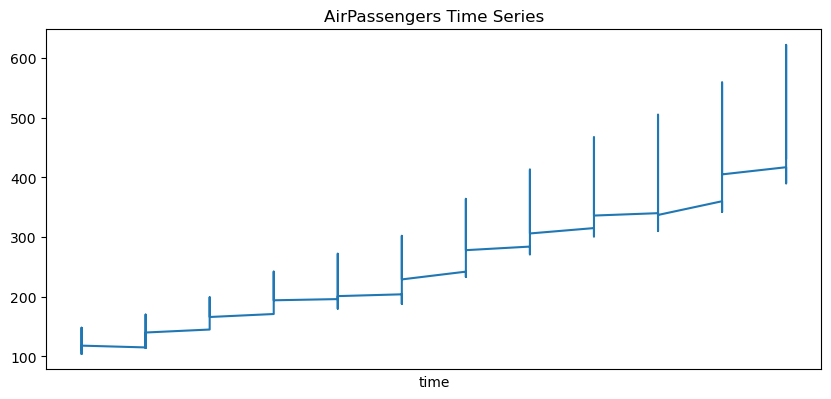

In [11]:
# Plotar serie AirPassengers
plt.figure(figsize = (10, 5))
air_series.plot(title = 'AirPassengers Time Series')

In [13]:
# Previsao sazonal naive (ultimo padrao sazonal repetido)
last_year = air_series[-12 : ] # Ultimo ano de dados
prev3 = pd.Series(np.tile(last_year.values, 1)[ : 12], # Repete o padrao
                  index = pd.date_range(start = air_series.index[-1] + pd.DateOffset(months = 1), periods = 12, freq = 'ME'))

print(
f"""
[Previsao Naive Sazonal]:

{prev3}
""")


[Previsao Naive Sazonal]:

1970-02-28 00:00:00.000001960    417
1970-03-31 00:00:00.000001960    391
1970-04-30 00:00:00.000001960    419
1970-05-31 00:00:00.000001960    461
1970-06-30 00:00:00.000001960    472
1970-07-31 00:00:00.000001960    535
1970-08-31 00:00:00.000001960    622
1970-09-30 00:00:00.000001960    606
1970-10-31 00:00:00.000001960    508
1970-11-30 00:00:00.000001960    461
1970-12-31 00:00:00.000001960    390
1971-01-31 00:00:00.000001960    432
Freq: ME, dtype: int64



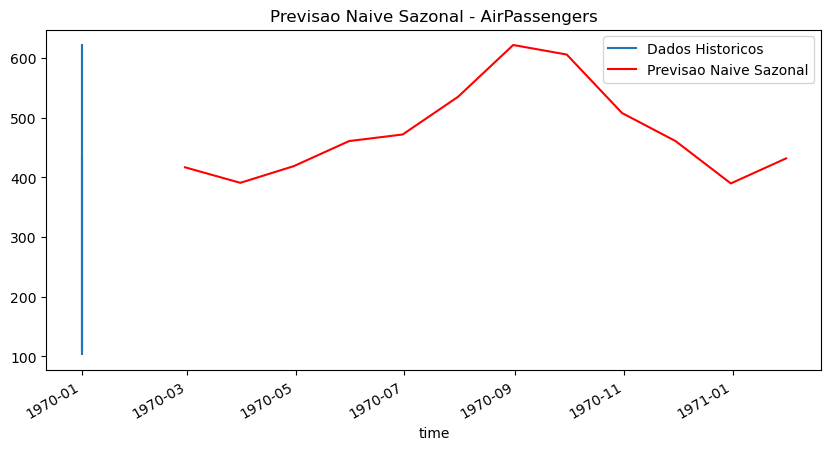

In [14]:
# Plotar previsão sazonal
plt.figure(figsize = (10, 5))
air_series.plot(label = 'Dados Historicos')
prev3.plot(label = 'Previsao Naive Sazonal', color = 'red')
plt.title('Previsao Naive Sazonal - AirPassengers')
plt.legend()

In [15]:
# Comparar com o ultimo ano
print(
f"""
[Ultimo ano de dados]:

{air_series}"""
)


[Ultimo ano de dados]:

time
1970-01-01 00:00:00.000001949    112
1970-01-01 00:00:00.000001949    118
1970-01-01 00:00:00.000001949    132
1970-01-01 00:00:00.000001949    129
1970-01-01 00:00:00.000001949    121
                                ... 
1970-01-01 00:00:00.000001960    606
1970-01-01 00:00:00.000001960    508
1970-01-01 00:00:00.000001960    461
1970-01-01 00:00:00.000001960    390
1970-01-01 00:00:00.000001960    432
Name: value, Length: 144, dtype: int64
